In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [3]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [4]:
popular_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','puma','fila']

df_shoes = df_shoes[df_shoes['brand'].isin(popular_brands)]

['olympikus', 'nike', 'adidas', 'asics', 'puma', 'mizuno', 'fila']


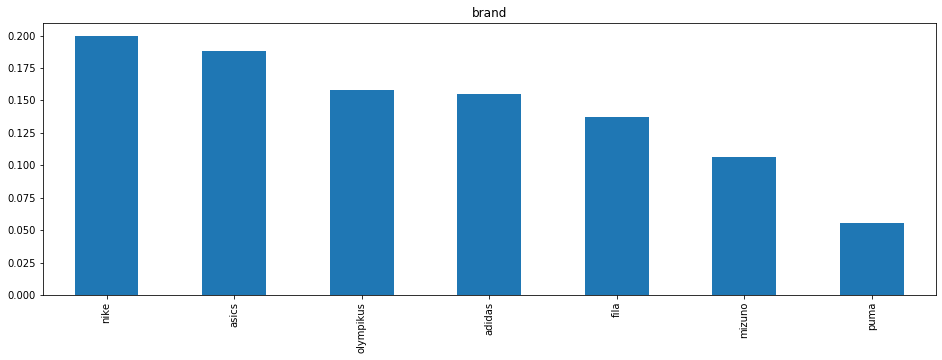

In [5]:
print(list(df_shoes['brand'].unique()))
    
plot_value_counts(df_shoes,'brand','bar')

# Preprocessing Functions

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [17]:
IMG_SHAPE = (240,240)
epochs = 100
drop_rate = 0.2

checkpoint_path = './brand_model/original_lr0003_3convs_batch_norm_last_drop02_2'

if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)

    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(drop_rate),
        BatchNormalization(),
        Dense(df_shoes['brand'].nunique())
    ])
    initial_epoch = 300
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

NameError: name 'aaaaaaaa' is not defined

In [9]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','brand']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(17495, 2)

In [10]:
train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=64,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

Found 14870 validated image filenames belonging to 7 classes.
Found 1968 validated image filenames belonging to 7 classes.
Found 657 validated image filenames belonging to 7 classes.


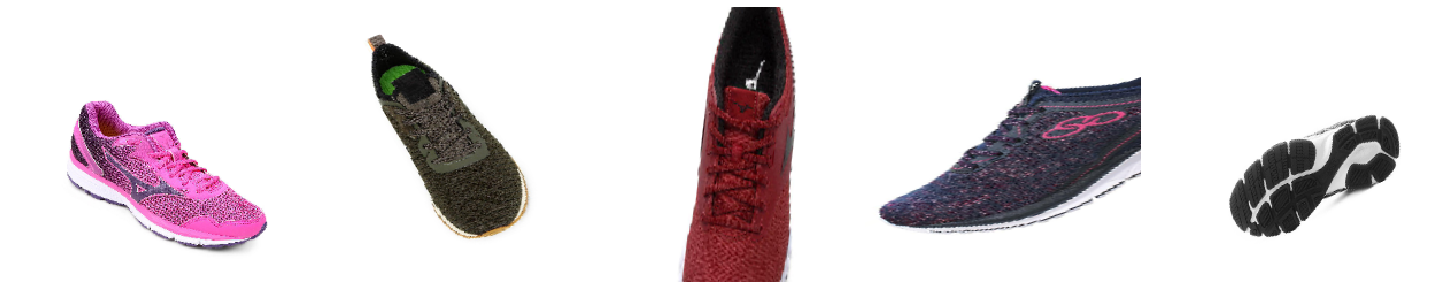

In [11]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [18]:
learning_rate = 0.003
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     learning_rate,
#     decay_steps=500,
#     decay_rate=0.96,
#     staircase=True)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

if(initial_epoch == 0):
    run = ''
else:
    run = '_3'
    
logdir = f"{checkpoint_path}{run}/logs/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]



history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=initial_epoch + epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=initial_epoch
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 232 steps, validate for 30 steps
Epoch 101/200
232/232 [==============================] - 311s 1s/step - loss: 0.8894 - acc: 0.6726 - val_loss: 1.2879 - val_acc: 0.6281
Epoch 102/200
232/232 [==============================] - 311s 1s/step - loss: 0.8917 - acc: 0.6698 - val_loss: 1.2530 - val_acc: 0.6276
Epoch 103/200
232/232 [==============================] - 312s 1s/step - loss: 0.8873 - acc: 0.6695 - val_loss: 1.0406 - val_acc: 0.6677
Epoch 104/200
232/232 [==============================] - 310s 1s/step - loss: 0.8801 - acc: 0.6718 - val_loss: 1.2256 - val_acc: 0.6187
Epoch 105/200
232/232 [==============================] - 310s 1s/step - loss: 0.8847 - acc: 0.6760 - val_loss: 1.2627 - val_acc: 0.6443
Epoch 106/200
232/232 [==============================] - 309s 1s/step - loss: 0.8861 - acc: 0.6741 - val_loss: 1.3967 - val_acc: 0.5984
Epoch 107/200
232/232 [==============================] - 309s 1s/step - loss: 0.8785 - acc:

Epoch 153/200
232/232 [==============================] - 303s 1s/step - loss: 0.8396 - acc: 0.6957 - val_loss: 1.1866 - val_acc: 0.6604
Epoch 154/200
232/232 [==============================] - 303s 1s/step - loss: 0.8345 - acc: 0.6936 - val_loss: 1.1683 - val_acc: 0.6552
Epoch 155/200
232/232 [==============================] - 303s 1s/step - loss: 0.8385 - acc: 0.6924 - val_loss: 1.0739 - val_acc: 0.6781
Epoch 156/200
232/232 [==============================] - 302s 1s/step - loss: 0.8418 - acc: 0.6877 - val_loss: 1.3177 - val_acc: 0.6385
Epoch 157/200
232/232 [==============================] - 302s 1s/step - loss: 0.8352 - acc: 0.6928 - val_loss: 1.2694 - val_acc: 0.6620
Epoch 158/200
232/232 [==============================] - 302s 1s/step - loss: 0.8459 - acc: 0.6878 - val_loss: 1.5896 - val_acc: 0.6031
Epoch 159/200
232/232 [==============================] - 302s 1s/step - loss: 0.8297 - acc: 0.6982 - val_loss: 1.3533 - val_acc: 0.6120
Epoch 160/200
232/232 [=========================

In [19]:
model = tf.keras.models.load_model(checkpoint_path)

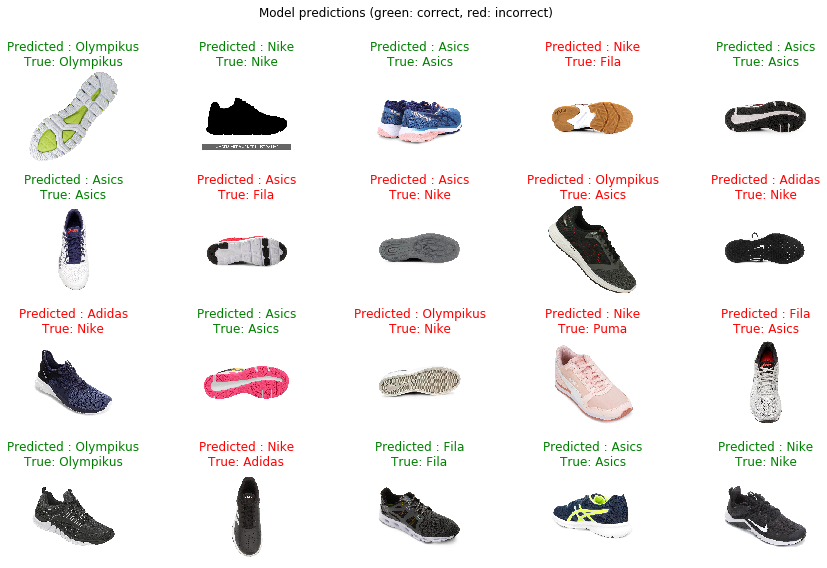

In [27]:
class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [21]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)

  ...
    to  
  ['...']
31/31 [==============================] - 25s 801ms/step - loss: 1.0132 - acc: 0.6941
  ...
    to  
  ['...']
11/11 [==============================] - 8s 708ms/step - loss: 1.0055 - acc: 0.6925


[1.0055324597792192, 0.69254184]